In [1]:
from collections import defaultdict
import itertools
import os
from pathlib import Path
import random
import time

import IPython.display

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow_addons as tfa
import math

2022-08-06 14:04:18.191586: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
random.seed(42)

In [3]:
reber_grammar = {
        0: [(1, "B")],
        1: [(2, "T"), (3, "P")],
        2: [(2, "S"), (4, "X")],
        3: [(3, "T"), (5, "V")],
        4: [(3, "X"), (6, "S")],
        5: [(4, "P"), (6, "V")],
        6: [(7, "E")],
        7: [],
}

grammar_set = set(c for _, edges in reber_grammar.items() for _, c in edges)
grammar_size = len(grammar_set)

node_set = set(n for n, _ in reber_grammar.items()) - set([7])

# Ideally this would be the expected value of a reber string 
# but a lazy solution is to sample the average lengths of 
# strings empirically.
average_reber_string_length = 7.85
corruption_probability = 1 / average_reber_string_length

def gen_reber_sequence(grammar, valid=True):
    node = 0
    history = []
    corruptions = 0
    while grammar[node]:
        choice = random.choice(grammar[node])
        if not valid and corruptions == 0 and random.random() < corruption_probability:
            other_node = random.choice(list(node_set - set([node])))
            choice = random.choice(grammar[other_node])
            corruptions += 1
        history.append(choice)
        node = choice[0]
        
    return history, corruptions

def to_string(history):
    return "".join([c for _, c in history])

def gen_valid_reber_string(grammar):
    history, _ = gen_reber_sequence(grammar)
    return to_string(history)

def gen_invalid_reber_string(grammar):
    corruptions = 0
    while corruptions == 0:
        history, corruptions = gen_reber_sequence(grammar, valid=False)
    
    return to_string(history)

In [4]:
def reber_dataset(n_valid=1024, n_invalid=1024, batch_size=32):
    valid_sequences = [gen_valid_reber_string(reber_grammar) for _ in range(n_valid)]
    invalid_sequences = [gen_invalid_reber_string(reber_grammar) for _ in range(n_invalid)]
    sequences = valid_sequences + invalid_sequences
    labels = [1.]*len(valid_sequences) + [0.]*len(invalid_sequences)
    sequence_set = tf.data.Dataset.from_tensor_slices(sequences)
    label_set = tf.data.Dataset.from_tensor_slices(labels)
    
    return tf.data.Dataset.zip((sequence_set, label_set)) \
        .shuffle(n_valid + n_invalid) \
        .batch(batch_size) \
        .prefetch(1)

In [5]:
train_set = reber_dataset(n_valid=5000, n_invalid=5000)
val_set = reber_dataset(n_valid=1000, n_invalid=1000)
test_set = reber_dataset(n_valid=1000, n_invalid=1000)

2022-08-06 14:04:19.560158: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-06 14:04:20.022473: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22307 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:68:00.0, compute capability: 8.6


In [6]:
def base_log_dir():
    return os.path.join(os.curdir, ".tflogs", "reber_grammar")

def get_tensorboard_cb(callback=keras.callbacks.TensorBoard):
    base_dir = base_log_dir()
    run_id = time.strftime("run_%Y_%m_%d_%H_%M_%S")
    run_dir = os.path.join(base_dir, run_id)
    return callback(run_dir)

In [7]:
def build_model(train_set, optimizer=keras.optimizers.Adam, embedding_size=5, n_neurons=32, n_layers=2, learning_rate=1e-3, clipnorm=1.0):
    max_len = max(len(s) for s, _ in train_set.unbatch().as_numpy_iterator())
    text_layer = keras.layers.TextVectorization(split="character", max_tokens=grammar_size, output_mode="int")
    text_layer.adapt(train_set.map(lambda X, Y: X))
    
    model = keras.models.Sequential([
        text_layer,
        # keras.layers.Lambda(lambda X: tf.one_hot(X, grammar_size)),
        keras.layers.Embedding(input_dim=grammar_size, output_dim=embedding_size, mask_zero=True)
    ])
    for _ in range(n_layers - 1):
        model.add(keras.layers.LSTM(n_neurons, return_sequences=True))
    
    model.add(keras.layers.LSTM(n_neurons))
    model.add(keras.layers.Dense(1, activation="sigmoid"))
    
    model.compile(
        loss="binary_crossentropy",
        optimizer=optimizer(learning_rate=learning_rate, clipnorm=clipnorm),
        metrics=["accuracy"],
    )
    
    return model

In [8]:
class LearningRateCallback(keras.callbacks.Callback):
    def __init__(self, initial_learning_rate, final_learning_rate, steps):
        self.factor = math.exp(math.log(final_learning_rate/float(initial_learning_rate))/steps)
        self.losses = []
        self.learning_rates = []
    
    def on_batch_end(self, batch, logs):
        self.losses.append(logs.get("loss"))
        learning_rate = keras.backend.get_value(self.model.optimizer.learning_rate)
        self.learning_rates.append(learning_rate)
        keras.backend.set_value(self.model.optimizer.learning_rate, learning_rate*self.factor)

def find_best_learning_rate(
    train_set,
    val_set,
    compiled_model, 
    n_steps=500,
    learning_rate_min=1e-5, 
    learning_rate_max=1e-1,
    ):
    keras.backend.clear_session()
    np.random.seed(42)
    tf.random.set_seed(42)  
    
    learning_rate_callback = LearningRateCallback(learning_rate_min, learning_rate_max, n_steps)
    
    history = compiled_model.fit(
      train_set,
      epochs=1,
      steps_per_epoch=n_steps,
      validation_data=val_set,
      callbacks=[learning_rate_callback],
    )
    
    
    learning_rates = np.array(learning_rate_callback.learning_rates)
    losses = np.array(learning_rate_callback.losses)
    idx = losses < 10000
    learning_rates_clean = learning_rates[idx]
    losses_clean = losses[idx]
    
    plt.plot(learning_rates_clean, losses_clean)
    best_idx = np.argmin(losses_clean)
    best_learning_rate = learning_rates[best_idx] / 10.
    return best_learning_rate

In [9]:
def train_model(
    train_set, 
    val_set, 
    compiled_model, 
    callbacks=None,
    n_epochs=500,
    steps_per_epoch=None,
    tensorboard_callback=keras.callbacks.TensorBoard,
    ):
    callbacks = callbacks or []
    keras.backend.clear_session()
    np.random.seed(42)
    tf.random.set_seed(42)
    
    builtin_callbacks = [
        keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
        get_tensorboard_cb(callback=tensorboard_callback),
    ]
    
    history = compiled_model.fit(
        train_set,
        epochs=n_epochs,
        steps_per_epoch=steps_per_epoch,
        validation_data=val_set,
        callbacks=callbacks + builtin_callbacks,
    )

2022-08-06 14:04:27.298617: W tensorflow/core/common_runtime/forward_type_inference.cc:231] Type inference failed. This indicates an invalid graph that escaped type checking. Error message: INVALID_ARGUMENT: expected compatible input types, but input 1:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_LEGACY_VARIANT
    }
  }
}
 is neither a subtype nor a supertype of the combined inputs preceding it:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_FLOAT
    }
  }
}

	while inferring type of node 'cond_40/output/_19'
2022-08-06 14:04:28.027964: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2022-08-06 14:04:28.818269: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


300/300 [==============================] - 14s 27ms/step - loss: 0.6870 - accuracy: 0.5149 - val_loss: 0.7065 - val_accuracy: 0.5000


0.008254045248031616

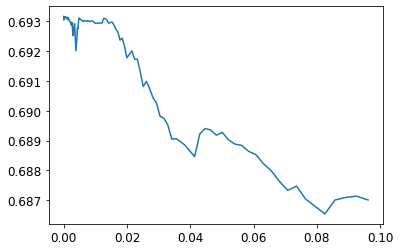

In [10]:
model = build_model(train_set, learning_rate=1e-6)
best_learning_rate = find_best_learning_rate(train_set, val_set, model, learning_rate_min=1e-6, learning_rate_max=1e-1, n_steps=300)
best_learning_rate

In [11]:
5e-5 * .9

4.5e-05

In [12]:
# lr_schedule = keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate=5e-5,
#     decay_steps=500,
#     decay_rate=0.9)
model = build_model(train_set, learning_rate=1e-3, n_neurons=32, n_layers=2)

train_model(train_set, val_set, model)

for X, Y in train_set.take(1):
    print(model(X))
    print(Y)

Epoch 1/500
313/313 [==============================] - 13s 25ms/step - loss: 0.6804 - accuracy: 0.5498 - val_loss: 0.6589 - val_accuracy: 0.6195
Epoch 2/500
313/313 [==============================] - 6s 20ms/step - loss: 0.5841 - accuracy: 0.6777 - val_loss: 0.5078 - val_accuracy: 0.7395
Epoch 3/500
313/313 [==============================] - 6s 20ms/step - loss: 0.3891 - accuracy: 0.8040 - val_loss: 0.3111 - val_accuracy: 0.8350
Epoch 4/500
313/313 [==============================] - 6s 20ms/step - loss: 0.2686 - accuracy: 0.8678 - val_loss: 0.2119 - val_accuracy: 0.8950
Epoch 5/500
313/313 [==============================] - 6s 20ms/step - loss: 0.1852 - accuracy: 0.9180 - val_loss: 0.1822 - val_accuracy: 0.9175
Epoch 6/500
313/313 [==============================] - 6s 20ms/step - loss: 0.1534 - accuracy: 0.9294 - val_loss: 0.1612 - val_accuracy: 0.9285
Epoch 7/500
313/313 [==============================] - 6s 20ms/step - loss: 0.1063 - accuracy: 0.9572 - val_loss: 0.0891 - val_accuracy

In [15]:
model.evaluate(test_set)

63/63 [==============================] - 1s 9ms/step - loss: 0.0039 - accuracy: 0.9995


[0.0038858396001160145, 0.9994999766349792]

In [16]:
wrong_train_set = train_set.unbatch().batch(1).filter(lambda x, y: tf.math.abs(model(x)[0][0] - y[0]) > 0.5)
wrong_val_set = val_set.unbatch().batch(1).filter(lambda x, y: tf.math.abs(model(x)[0][0] - y[0]) > 0.5)

print("train")
for x, y in wrong_train_set:
    print("===========================")
    print(x[0])
    print(model(x)[0][0])
    print(y[0])
    
print("val")
for x, y in wrong_val_set:
    print("===========================")
    print(x[0])
    print(model(x)[0][0])
    print(y[0])

train
val
tf.Tensor(b'BTSXXTTTVTTTTVVE', shape=(), dtype=string)
tf.Tensor(0.86173546, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)


In [27]:
for x, y in val_set.unbatch().batch(1).filter(lambda x, y: tf.strings.regex_full_match(x, ".*TTTVTTTTVVE")[0]):
    print(x)
    print(y)

tf.Tensor([b'BTSXXTTTVTTTTVVE'], shape=(1,), dtype=string)
tf.Tensor([0.], shape=(1,), dtype=float32)
